# Automated Visual Weak Supervision for Object Recognition in Videos

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import random
import numpy as np
np.random.seed(695)
from sklearn import metrics
import matplotlib.pyplot as plt

from process_tubes import *
from reef_label_tubes import reef_label
import ClassifierLoader
from tube_classifier import *

NUM_FRAMES_PER_TUBE = 30

/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using device: cuda


## 1. Split the Dataset

Here, we split our dataset into an unlabeled train set (30 objects), a labeled validation set (300), and a labeled test set (70). Each object maps to an action tube consisting of 30 frames.

In [2]:
labeled_vehicles, unlabeled_vehicles, test_vehicles = get_objects((30, 300, 70))

print(labeled_vehicles.shape[0], 'labeled train examples')
print(unlabeled_vehicles.shape[0], 'unlabeled train examples')
print(test_vehicles.shape[0], 'labeled test examples')

30 labeled train examples
300 unlabeled train examples
70 labeled test examples


## 2. Create Action Tubes for Weak Supervision

At this step, we read in our frames, encode them with our optimized convolutional autoencoder, and concatenate them to make action tubes.

In [3]:
val_primitive_matrix, val_tubes = tube_loader(labeled_vehicles, label = True)
val_ground = [label for tube in val_tubes for label in tube.tube_true_labels]

Producing action tubes...
Creating action tube for object index 4008
Creating action tube for object index 2148
Creating action tube for object index 2619
Creating action tube for object index 2488
Creating action tube for object index 4115
Creating action tube for object index 2921
Creating action tube for object index 2506
Creating action tube for object index 1480
Creating action tube for object index 105
Creating action tube for object index 705
Creating action tube for object index 547
Creating action tube for object index 3598
Creating action tube for object index 4057
Creating action tube for object index 1559
Creating action tube for object index 3996
Creating action tube for object index 3792
Creating action tube for object index 3197
Creating action tube for object index 3973
Creating action tube for object index 80
Creating action tube for object index 3190
Creating action tube for object index 302
Creating action tube for object index 3472
Creating action tube for object in

In [4]:
train_primitive_matrix, train_tubes = tube_loader(unlabeled_vehicles, label = True)
train_ground = [label for tube in train_tubes for label in tube.tube_true_labels]

Producing action tubes...
Creating action tube for object index 2470
Creating action tube for object index 3365
Creating action tube for object index 3298
Creating action tube for object index 4107
Creating action tube for object index 2908
Creating action tube for object index 32
Creating action tube for object index 1351
Creating action tube for object index 2691
Creating action tube for object index 3409
Creating action tube for object index 3161
Creating action tube for object index 1563
Creating action tube for object index 3891
Creating action tube for object index 2298
Creating action tube for object index 341
Creating action tube for object index 3427
Creating action tube for object index 2990
Creating action tube for object index 3085
Creating action tube for object index 177
Creating action tube for object index 3266
Creating action tube for object index 3725
Creating action tube for object index 259
Creating action tube for object index 2346
Creating action tube for object i

Creating action tube for object index 4145
Creating action tube for object index 3274
Creating action tube for object index 3872
Creating action tube for object index 3620
Creating action tube for object index 4035
Creating action tube for object index 3367
Creating action tube for object index 3512
Creating action tube for object index 3809
Creating action tube for object index 64
Creating action tube for object index 2521
Creating action tube for object index 3920
Creating action tube for object index 3151
Creating action tube for object index 4009
Creating action tube for object index 3189
Creating action tube for object index 437
Creating action tube for object index 2682
Creating action tube for object index 2707
Creating action tube for object index 2197
Creating action tube for object index 874
Creating action tube for object index 3555
Creating action tube for object index 4085
Creating action tube for object index 2051
Creating action tube for object index 3983
Creating action

In [6]:
test_primitive_matrix, test_tubes = tube_loader(test_vehicles, label = True)
test_ground = [label for tube in test_tubes for label in tube.tube_true_labels]

Producing action tubes...
Creating action tube for object index 5
Creating action tube for object index 2006
Creating action tube for object index 2820
Creating action tube for object index 1629
Creating action tube for object index 3133
Creating action tube for object index 3933
Creating action tube for object index 170
Creating action tube for object index 2019
Creating action tube for object index 380
Creating action tube for object index 2891
Creating action tube for object index 3766
Creating action tube for object index 2770
Creating action tube for object index 3413
Creating action tube for object index 8
Creating action tube for object index 1246
Creating action tube for object index 3352
Creating action tube for object index 3964
Creating action tube for object index 860
Creating action tube for object index 2646
Creating action tube for object index 2015
Creating action tube for object index 2857
Creating action tube for object index 3165
Creating action tube for object index

In [7]:
# print(val_ground)
# print(train_ground)
print(train_ground.count(-1))
print(train_ground.count(1))
print(len(train_ground))

print(val_ground.count(-1))
print(val_ground.count(1))
print(len(val_ground))

# val_ground_pos = [1] * 450
# val_ground_neg = [-1] * 450
# val_ground = val_ground_pos + val_ground_neg

# print(val_ground.count(-1))
# print(val_ground.count(1))
# print(len(val_ground))


4050
4950
9000
420
480
900


## 3. Apply Visual Weak Supervision

To perform visual weak supervision, we pass our frame encodings from the unlabeled train set and our labeled validation set into Reef. Note that we have already tested various methods for weak supervision, and so the `train_ground` parameter is not used here. Please refer to the `generate*.ipynb` notebooks to see our weak supervision experiments.

In [8]:
unlabeled_frame_nums = [frame_num for tube in train_tubes for frame_num in tube.sampled_frames]
weak_train = reef_label(train_primitive_matrix, val_primitive_matrix, val_ground, None, unlabeled_frame_nums)

Running iteration:  5
Running iteration:  10
Running iteration:  15
Running iteration:  20


## 4. Weakly Label Training Tubes

In the previous step, we generate probabilistic weak labels for each frame. Here, we aggregate all the frame-level labels for all frames in the tube and assign the tube the majority label. This step is necessary for future tube-level classification.

In [9]:
for tube in train_tubes:
    tube.assign_label(weak_train)
    print(tube.pred_vehicle, tube.true_vehicle)
    
for tube in val_tubes:
    tube.true_vehicle = 0 if tube.true_vehicle == -1 else 1
    print(tube.true_vehicle)

1 1
1 1
1 1
1 -1
1 -1
1 1
1 1
0 1
0 -1
1 -1
0 1
1 1
1 1
1 -1
0 -1
1 -1
0 -1
1 1
1 -1
0 -1
1 -1
1 1
1 1
1 -1
1 -1
0 -1
1 1
1 1
0 -1
1 1
1 1
1 -1
1 1
1 1
0 -1
1 -1
1 1
1 -1
1 1
1 -1
0 1
1 1
0 1
1 1
1 -1
1 -1
0 -1
1 -1
0 1
1 -1
1 1
1 1
1 -1
1 1
1 1
0 -1
0 -1
1 1
1 1
1 1
1 1
0 1
0 -1
1 -1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 -1
0 -1
1 1
0 1
1 1
1 1
1 -1
0 -1
1 -1
1 -1
1 -1
0 1
1 1
1 1
1 1
1 -1
1 1
1 -1
0 1
1 1
1 -1
1 -1
1 1
1 1
0 -1
1 -1
0 1
1 -1
0 1
1 1
0 1
1 1
0 -1
1 -1
1 1
1 1
1 1
1 1
1 -1
1 1
1 1
0 1
1 1
1 -1
1 -1
1 1
1 1
1 1
1 -1
1 -1
1 1
1 -1
0 1
1 -1
1 1
1 1
1 1
1 1
1 1
1 1
0 -1
1 -1
1 1
1 1
1 -1
0 -1
1 1
0 1
1 -1
1 1
0 1
1 1
1 -1
0 1
1 -1
1 -1
1 1
1 1
1 -1
1 -1
1 -1
1 -1
1 1
1 1
1 -1
1 1
1 -1
1 1
1 1
1 1
1 -1
1 1
0 1
0 -1
1 1
1 1
1 -1
1 -1
1 -1
1 -1
0 -1
0 1
1 1
0 -1
1 1
0 1
1 1
1 -1
1 1
1 -1
1 -1
1 -1
0 -1
1 1
1 1
1 1
1 1
1 -1
1 -1
1 1
1 1
1 -1
1 -1
1 1
0 -1
1 1
0 -1
1 -1
1 -1
1 1
1 1
0 1
1 -1
1 1
1 1
0 -1
1 -1
1 1
0 1
1 -1
0 1
1 1
0 -1
0 1
1 1
1 1
1 1
1 -1
0 -1
1 -1
1 -1
1 -1
1 -1
1 -1


## 5. Run Classifier

Here, we demonstrate hyperparameter tuning with our final 3D-CNN classifier built on our weakly-labeled tubes. This classifier assigns a given tube either a 1 (for car) or a 0 (for truck). We have conducted several experiments that involve varying the volume of weakly-labeled data passed into the classifier and monitor relative performance.

### Experiments:
1. Learning rate modulation for each of the following weak volume levels.
2. Weak volume: 0
2. Weak volume: 100
3. Weak volume: 200
4. Weak volume: 300

In [10]:
num_frames_per_tube = 30
code_size = 512

def run_classifier(train_primitive_matrix, train_tubes, val_primitive_matrix, val_tubes, \
                   test_primitive_matrix, test_tubes, lr_arr, weak_volume):
    if weak_volume != 0:
        train_primitive_matrix_trunc = train_primitive_matrix[0:num_frames_per_tube*weak_volume, :]
        train_tubes_trunc = train_tubes[0:weak_volume]

        # combine data
        merged_primitive_matrix = torch.cat((train_primitive_matrix_trunc, val_primitive_matrix), 0)
        merged_tubes = train_tubes_trunc + val_tubes
    else:
        merged_primitive_matrix = val_primitive_matrix
        merged_tubes = val_tubes
        
    # shuffle and perform a second standard split (80 train: 20 val)
    num_train = 4 * len(merged_tubes)//5
    train_inds = random.sample(range(0, len(merged_tubes)), num_train)
    val_inds = list(set(np.arange(0, len(merged_tubes))) - set(train_inds))

    merged_primitive_matrix = merged_primitive_matrix.view(-1, num_frames_per_tube, code_size)
    
    train_x = merged_primitive_matrix[train_inds, :, :]
    train_x = train_x.view(-1, code_size)
    train_y = [merged_tubes[i] for i in train_inds]

    val_x = merged_primitive_matrix[val_inds, :, :]
    val_x = val_x.view(-1, code_size)
    val_y = [merged_tubes[i] for i in val_inds]
    
    # run classifier
    return tune(train_x, train_y, val_x, val_y, test_primitive_matrix, test_tubes, lr_arr, weak_volume)

In [18]:
# define hyperparameters
lr_arr = [1e-5, 1e-4, 1e-3, 1e-2]
weak_increment = unlabeled_vehicles.shape[0] // 3
weak_volume_arr = [0, weak_increment, 2*weak_increment, 3*weak_increment] # 0, 100, 200, 300

weak_volume_results = {}

for weak_volume in weak_volume_arr:
    print('\nWeak volume level:', weak_volume)
    lr_metrics = run_classifier(train_primitive_matrix, train_tubes, \
                               val_primitive_matrix, val_tubes, test_primitive_matrix, test_tubes, lr_arr, weak_volume)
    weak_volume_results[weak_volume] = lr_metrics

Using device: cuda

Weak volume level: 0
24 examples in train set
6 examples in validation set
70 examples in test set
Learning Rate = 0.00001, loss = 0.39747, valacc = 0.500
Learning Rate = 0.00010, loss = 0.31488, valacc = 0.667
Learning Rate = 0.00100, loss = 0.81326, valacc = 0.667
Learning Rate = 0.01000, loss = 0.81326, valacc = 0.333

Weak volume level: 100
104 examples in train set
26 examples in validation set
70 examples in test set
Learning Rate = 0.00001, loss = 0.58144, valacc = 0.769
Learning Rate = 0.00010, loss = 0.31705, valacc = 0.808
Learning Rate = 0.00100, loss = 0.63057, valacc = 0.769
Learning Rate = 0.01000, loss = 0.63057, valacc = 0.769

Weak volume level: 200
184 examples in train set
46 examples in validation set
70 examples in test set
Learning Rate = 0.00001, loss = 0.56340, valacc = 0.739
Learning Rate = 0.00010, loss = 0.68820, valacc = 0.739
Learning Rate = 0.00100, loss = 0.58112, valacc = 0.739
Learning Rate = 0.01000, loss = 0.65255, valacc = 0.739



## 6. Visualize Results

Above, we created a cohort of models by interating over various weak volume levels and learning rates. For each model, we saved the loss history (our primary metric), the predicted scores, the true labels (derived from weak supervision), and the accuracy. Here, we will plot these values.

### Prepare Test Dataset

[0, 100, 200, 300]
[1e-05, 0.0001, 0.001, 0.01]
For the model with a weak volume of 0 and learning rate of 1e-05
0.3
For the model with a weak volume of 0 and learning rate of 0.0001
0.35714285714285715
For the model with a weak volume of 0 and learning rate of 0.001
0.5571428571428572
For the model with a weak volume of 0 and learning rate of 0.01
0.0
For the model with a weak volume of 100 and learning rate of 1e-05
0.5571428571428572
For the model with a weak volume of 100 and learning rate of 0.0001
0.5285714285714286
For the model with a weak volume of 100 and learning rate of 0.001
0.5571428571428572
For the model with a weak volume of 100 and learning rate of 0.01
0.5571428571428572
For the model with a weak volume of 200 and learning rate of 1e-05
0.5571428571428572
For the model with a weak volume of 200 and learning rate of 0.0001
0.5571428571428572
For the model with a weak volume of 200 and learning rate of 0.001
0.5571428571428572
For the model with a weak volume of 200 an

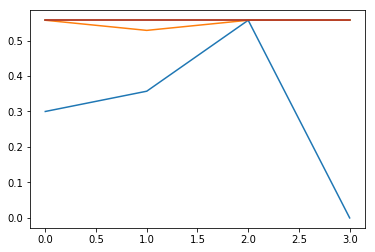

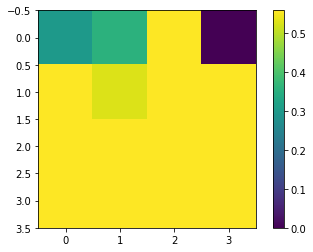

In [57]:
# test_primitive_matrix, test_tubes = tube_loader(test_vehicles, label = True)
# test_ground = [label for tube in test_tubes for label in tube.tube_true_labels]

toPlot = np.zeros((len(weak_volume_arr), len(lr_arr)))

print(weak_volume_arr)
print(lr_arr)

i = 0
for weak_volume in weak_volume_arr:
    rateSeries = np.zeros((len(lr_arr)))
    j = 0
    for lr in lr_arr:
        loss_hist, scores, y, val_acc, test_acc = weak_volume_results[weak_volume][lr]
        # _, _, _, _, test_acc = weak_volume_results[weak_volume][lr]
        print("For the model with a weak volume of", weak_volume, "and learning rate of", lr)
        print(test_acc)
        toPlot[i,j] = test_acc
        rateSeries[j] = test_acc
        j += 1
    i += 1
    plt.plot(rateSeries)

print(toPlot)
    
plt.show()
plt.imshow(toPlot)
plt.colorbar()

### Comparison

### Loss Curves

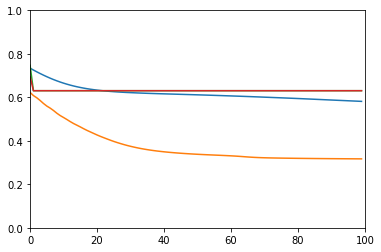

In [51]:
for weak_volume in [100]:
    for lr in lr_arr:
        loss_hist, _, _, acc, _ = weak_volume_results[weak_volume][lr]
        
#         print(loss_hist)
#         print("ACCURACY", acc)
        # print(loss_hist)
        plt.plot(loss_hist)

    plt.axis([0, 100, 0, 1])
    plt.figure(figsize = (50, 25))
    plt.show()

### ROC Curves

[0.87096864, 0.6176559, 0.34729838, 0.5018725, 0.6844038, 0.7385999] [1, 0, 1, 1, 1, 0]
0.375
[0.7330788, 0.29659745, 0.5864158, 0.28244418, 0.5935864, 0.8287435] [0, 1, 0, 1, 1, 1]
0.375
[1.595191e-07, 2.4092927e-08, 2.7841827e-07, 2.6350605e-08, 2.1550264e-08, 4.2914095e-08] [0, 0, 1, 1, 1, 1]
0.5
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0, 1, 1, 0, 1, 1]
0.5
[0.1737871, 0.36120906, 0.307027, 0.2382309, 0.36108473, 0.28178218, 0.15764435, 0.1469292, 0.15729278, 0.16528435, 0.1797693, 0.3924589, 0.49897465, 0.41346413, 0.11688716, 0.292917, 0.20760703, 0.0911169, 0.17824121, 0.1888052, 0.099102825, 0.17272954, 0.1844682, 0.23462433, 0.13495278, 0.21096237] [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]
0.31666666666666665
[0.043887176, 0.33729124, 0.0890275, 0.017564125, 0.12581491, 0.041383952, 0.16513954, 0.49523878, 0.14836797, 0.17060111, 0.27948844, 0.14349967, 0.7476489, 0.17258798, 0.15508166, 0.3059803, 0.014413699, 0.25091907, 0.21217582, 0.04220713, 0.

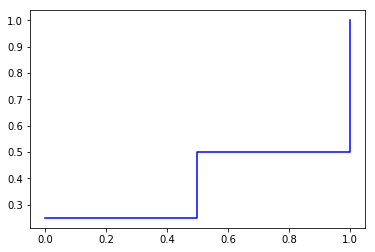

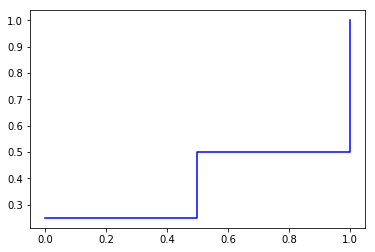

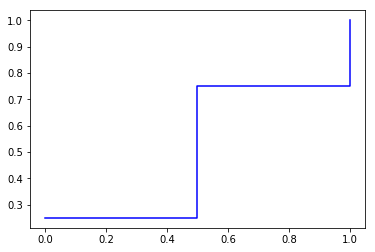

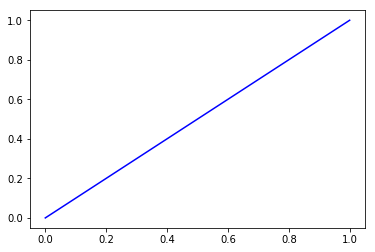

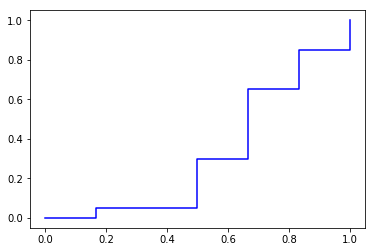

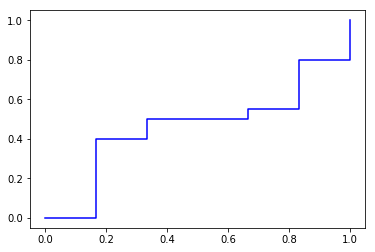

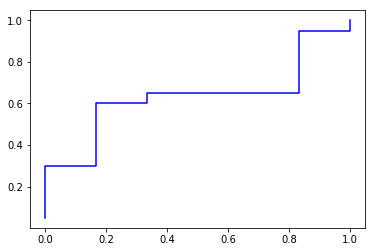

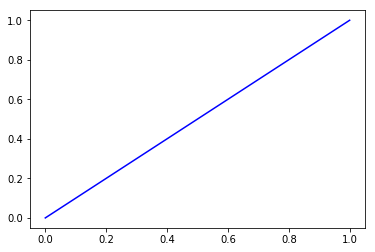

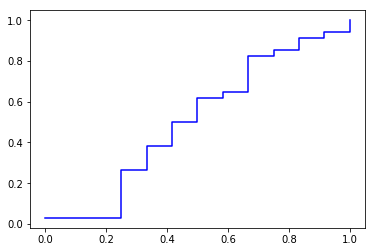

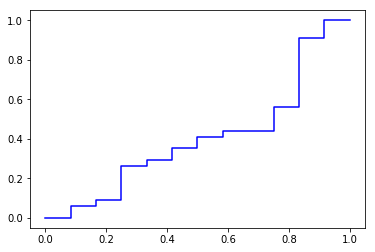

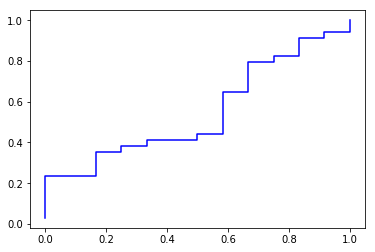

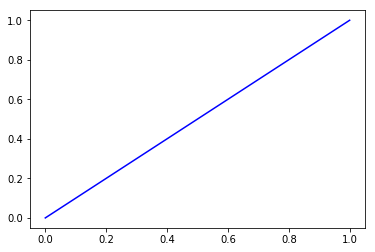

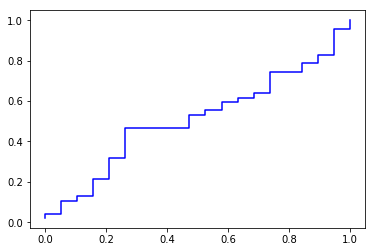

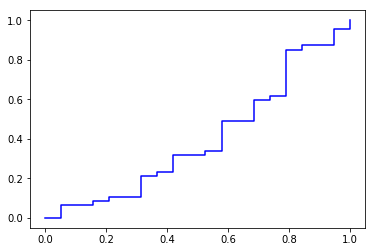

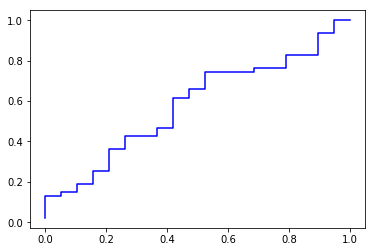

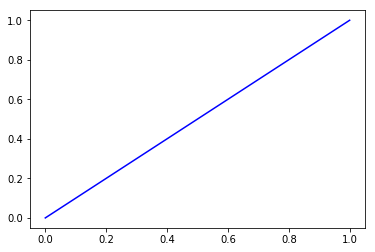

In [32]:
for weak_volume in weak_volume_arr:
    for lr in lr_arr:
        _, scores, y, _, _ = weak_volume_results[weak_volume][lr]
        print(scores, y)
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        print(roc_auc)
        plt.figure()
        plt.plot(fpr, tpr, color='blue')

In [ ]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    scores = model.forward(X)
    loss = torch.sum(scores.gather(1, y.view(-1, 1)).squeeze())
    loss.backward()
    # saliency = X.grad.gather(1, X.grad.argmax(1)[:,np.newaxis,:,:]).squeeze()
    saliency = torch.max(torch.abs(X.grad), 1)[0]
    pass
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

In [ ]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)